In [86]:
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

# torchvision
from torchvision import models
import torchvision.transforms.v2 as tfs_v2

# scikit-learn
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

# e.t.c.
import os
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from datetime import datetime

In [87]:
PROJECT_DIR_PATH = os.path.abspath(os.path.curdir)
DATASET_DIR_PATH = os.path.join(PROJECT_DIR_PATH, 'dataset')
NUM_CLASSES = 15

#### If using kaggle kernel

In [88]:
if ('kaggle/working' in PROJECT_DIR_PATH):
    input_dir = "/kaggle/input/x-ray-pytorch"
    output_dir = "/kaggle/working/dataset"
    
    os.makedirs(output_dir, exist_ok=True)
    
    if not os.path.exists(input_dir):
        raise FileNotFoundError(f'directory {input_dir} not exist')
    
    shutil.copytree(input_dir, output_dir, dirs_exist_ok=True)
    print("Копирование завершено")

Копирование завершено


In [89]:
class XRayDataset(data.Dataset):
    def __init__(self, path: str, type_file: str, num_classes: int, transform=None, unpack_parquet : bool = True):
        self.path = path
        self.type_file = type_file
        self.transform = transform
        self.num_classes = num_classes

        if (unpack_parquet):
            self.unpack_parquet()
        
        files_path = []
        targets = []
        dataset_path = os.path.join(path, type_file)
        
        try:
            with open(os.path.join(path, self.get_json_name()), 'r') as f:
                img_classes = json.load(f)
        except FileNotFoundError:
            print(f'File {self.get_json_name()} not founr')
        except json.JSONDecodeError:
            print('Error in the JSON format!')
        
        for img_name in os.listdir(dataset_path):
            img_targets = img_classes.get(img_name, [])
        
            if not img_targets:
                print(f'Warning! {img_name} has not target')
                continue
            
            files_path.append(os.path.join(dataset_path, img_name))
            targets.append(img_targets)
        
        self.df = pd.DataFrame({'path': files_path, 'target': targets})
        self.length = self.df.shape[0]

    def __getitem__(self, index: int):
        file_path, target = self.df.iloc[index]
        img = Image.open(file_path).convert('RGB')
        
        if (self.transform is not None):
            img = self.transform(img)
        
        multi_hot_target = torch.zeros(self.num_classes)
        multi_hot_target[target] = 1
        
        return img, multi_hot_target

    def __len__(self):
        return self.length

    def unpack_parquet(self) -> None:
        type_file_path = os.path.join(self.path, self.type_file)
        
        if os.path.exists(type_file_path):
            shutil.rmtree(type_file_path)
            
        os.makedirs(type_file_path, exist_ok=True)
            
        parquet_files = [f for f in os.listdir(self.path)
                         if f.startswith(self.type_file) and f.endswith('.parquet')]

        last_image_index = 0
        img_labels = dict()
                
        for file_name in tqdm(parquet_files, desc=f'Unpacking {self.type_file}'):
            df = pd.read_parquet(os.path.join(self.path, file_name))

            for idx, row in df.iterrows():
                last_image_index += 1
                img_name = f'image_{last_image_index}.png'
                img_path = os.path.join(type_file_path, img_name)
                
                if isinstance(row.image['bytes'], bytes):
                    with open(img_path, 'wb') as f:
                        f.write(row.image['bytes'])
                else:
                    img = Image.fromarray(row.image['bytes'])
                    img.save()
            
                img_labels[f"{img_name}"] = row.labels.tolist()
        
        with open(os.path.join(self.path, self.get_json_name()), 'w') as f:
            json.dump(img_labels, f, indent=2)
    
    def get_json_name(self):
        return f'{self.type_file}_classes.json'

In [90]:
class XRayDensenet121(nn.Module):
    def __init__(self, output_dim):
        super(XRayDensenet121, self).__init__()

        # self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        for param in self.model.features.parameters():
            param.requires_grad = False

        in_features = self.model.classifier.in_features
        
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, x):
        x = self.model(x)
        # x = F.sigmoid(x)
        return x

In [91]:
class Exec:
    def __init__(
            self,
            model: torch.nn.Module,
            num_class: int,
            device: str = 'cpu',
            optimizer=None,
            loss_function=None,
            save_compare_accuracy: float = 0.1,  # if new model better prev model more than 10%
            save_each_epoch: int = 1) -> None:

        self.device = device
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.num_class = int(num_class)
        self.save_compare_accuracy = save_compare_accuracy
        self.save_each_epoch = int(save_each_epoch)
        self.accuracy_list = []
        self.loss_mean_list = []
        self.accuracy_dict = dict()

    def fit(
            self,
            epochs: int,
            device,
            project_dir_path: str,
            train_dataset: torch.utils.data.Dataset,
            valid_dataset: torch.utils.data.Dataset | None = None,
            **kwargs) -> None:

        num_gpus = 0
        best_accurasy = 0

        # kwargs vars
        train_bs = 16
        valid_bs = 20
        model_name = 'densenet121_multi-class'

        self.accuracy_list = []
        self.loss_mean_list = []

        for key, value in kwargs.items():
            if key == 'train_bs':
                train_bs = value
            if key == 'valid_bs':
                valid_bs = value

        if torch.cuda.is_available():
            num_gpus = torch.cuda.device_count()
            torch.cuda.empty_cache()
            if num_gpus > 0:
                self.model = nn.DataParallel(self.model)

        modal_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        fit_path = os.path.join(
            project_dir_path, 'models', model_name, modal_start_time)
        os.makedirs(fit_path, exist_ok=True)

        self.accuracy_dict = {
            '50': [],
            '55': [],
            '60': [],
            '65': [],
            '70': [],
            '75': [],
            '80': [],
            '85': [],
            '90': [],
            '95': [],
        }

        t = -1
        for _e in range(epochs):
            self.model.train()

            loss_mean = 0  # среднее значение функции потерь (по эпохе)
            lm_count = 0  # текущее количество слагаемых

            train_data = data.DataLoader(
                train_dataset, batch_size=train_bs, shuffle=True)
            train_tqdm = tqdm(train_data, leave=True)

            for x_train, y_train in train_tqdm:
                x_train = x_train.to(device)
                y_train = y_train.to(device)

                self.optimizer.zero_grad()

                y_pred = self.model(x_train)
                loss = self.loss_function(y_pred, y_train)

                loss.backward()
                self.optimizer.step()

                lm_count += 1
                loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
                train_tqdm.set_description(
                    f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")

            valid_accuracy = {
                '50': 0,
                '55': 0,
                '60': 0,
                '65': 0,
                '70': 0,
                '75': 0,
                '80': 0,
                '85': 0,
                '90': 0,
                '95': 0,
            }
            if not valid_dataset is None:
                self.model.eval()
                valid_data = data.DataLoader(
                    valid_dataset, batch_size=valid_bs, shuffle=False)

                for x_valid, y_valid in tqdm(valid_data, leave=True):
                    t += 1
                    with torch.no_grad():
                        x_valid = x_valid.to(device)
                        y_valid = y_valid.to(device)

                        logits = self.model(x_valid)
                        y_pred = torch.sigmoid(logits)

                        if (t == 0):
                            print({
                            'y_valid': y_valid[0],
                            'logits': logits[0],
                            'y_pred': y_pred[0],
                            })

                        y_pred_50 = (y_pred > 0.50).float()
                        y_pred_55 = (y_pred > 0.55).float()
                        y_pred_60 = (y_pred > 0.60).float()
                        y_pred_65 = (y_pred > 0.65).float()
                        y_pred_70 = (y_pred > 0.70).float()
                        y_pred_75 = (y_pred > 0.75).float()
                        y_pred_80 = (y_pred > 0.80).float()
                        y_pred_85 = (y_pred > 0.85).float()
                        y_pred_90 = (y_pred > 0.90).float()
                        y_pred_95 = (y_pred > 0.95).float()

                        valid_accuracy['50'] += (y_pred_50 == y_valid).float().sum().item()
                        valid_accuracy['55'] += (y_pred_55 == y_valid).float().sum().item()
                        valid_accuracy['60'] += (y_pred_60 == y_valid).float().sum().item()
                        valid_accuracy['65'] += (y_pred_65 == y_valid).float().sum().item()
                        valid_accuracy['70'] += (y_pred_70 == y_valid).float().sum().item()
                        valid_accuracy['75'] += (y_pred_75 == y_valid).float().sum().item()
                        valid_accuracy['80'] += (y_pred_80 == y_valid).float().sum().item()
                        valid_accuracy['85'] += (y_pred_85 == y_valid).float().sum().item()
                        valid_accuracy['90'] += (y_pred_90 == y_valid).float().sum().item()
                        valid_accuracy['95'] += (y_pred_95 == y_valid).float().sum().item()
                        
                        # if (t == 0):
                        #     print(valid_accuracy['90'], type(valid_accuracy['90']))


                l = len(valid_dataset) * 15
                
                valid_accuracy['50'] /= l
                valid_accuracy['55'] /= l
                valid_accuracy['60'] /= l
                valid_accuracy['65'] /= l
                valid_accuracy['70'] /= l
                valid_accuracy['75'] /= l
                valid_accuracy['80'] /= l
                valid_accuracy['85'] /= l
                valid_accuracy['90'] /= l
                valid_accuracy['95'] /= l
                
                # self.accuracy_list.append(valid_accuracy)
                
                self.loss_mean_list.append(loss_mean)

            self.accuracy_dict['50'].append(valid_accuracy['50'])
            self.accuracy_dict['55'].append(valid_accuracy['55'])
            self.accuracy_dict['60'].append(valid_accuracy['60'])
            self.accuracy_dict['65'].append(valid_accuracy['65'])
            self.accuracy_dict['70'].append(valid_accuracy['70'])
            self.accuracy_dict['75'].append(valid_accuracy['75'])
            self.accuracy_dict['80'].append(valid_accuracy['80'])
            self.accuracy_dict['85'].append(valid_accuracy['85'])
            self.accuracy_dict['90'].append(valid_accuracy['90'])
            self.accuracy_dict['95'].append(valid_accuracy['95'])
            
            model_state_dict = {
                # 'tfs': self.transform.state_dict(),
                'opt': self.optimizer.state_dict(),
                'model': self.model.module.state_dict() if num_gpus > 1 else self.model.state_dict(),
                'epochs': _e + 1,
                'accuracy_dict': self.accuracy_dict,
                'accuracy_list': self.accuracy_list,
                'loss_mean_list': self.loss_mean_list,
            }

            # if (not valid_dataset is None) and (best_accurasy * (1 + self.save_compare_accuracy) < valid_accuracy):
            #     shutil.rmtree(f'{fit_path}/best_accuracy', ignore_errors=True)
            #     os.makedirs(f'{fit_path}/best_accuracy', exist_ok=True)
            #     torch.save(model_state_dict, f"{fit_path}/best_accuracy/epoch_{_e + 1}.tar")

            if (_e + 1) % self.save_each_epoch == 0 and self.save_each_epoch > 0:
                os.makedirs(f'{fit_path}/save_each_epoch', exist_ok=True)
                torch.save(model_state_dict, f"{fit_path}/save_each_epoch/epoch_{_e + 1}.tar")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    def evaluate(self, dataloader: torch.utils.data.DataLoader, device) -> tuple:

        all_labels = []
        all_preds = []
        all_probs = []

        self.model.eval()

        with torch.no_grad():
            for x_test, y_test in tqdm(dataloader, desc="Evaluating"):
                x_test = x_test.to(device)
                y_test = y_test.to(device)

                logist = self.model(x_test)
                probs = torch.softmax(logist, dim=1)
                _, y_pred = torch.max(probs, 1)

                all_labels.append(torch.argmax(y_test, dim=1))
                all_preds.append(y_pred.cpu())
                all_probs.append(probs.cpu())

        return (
            torch.cat(all_labels).cpu(),
            torch.cat(all_preds).cpu(),
            torch.cat(all_probs).cpu()
        )

In [92]:
class Diagram:
    def __init__(self):
        pass

    def show_stats_fit_by_epochs(self, accuracy: list, loss_mean: list) -> None:
        fig, ax1 = plt.subplots(figsize=(8, 4))

        for key, value in accuracy.items():
            ax1.plot(value, color=np.random.rand(3,), label=f'accuracy at threshold {key}%')
        
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Accuracy") 
        ax1.tick_params(axis="y", labelcolor="tab:blue")  # Цвет тиков

        loss_color = "tab:red" 

        ax2 = ax1.twinx()
        ax2.plot(loss_mean, color=loss_color, label='Loss')
        
        ax2.set_ylabel("Loss", color=loss_color)
        ax2.tick_params(axis="y", labelcolor=loss_color)
        ax2.spines['right'].set_color(loss_color)

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

        plt.tight_layout()
        plt.show()
      
    def multiclass_roc(self, labels, probs, num_classes, title='ROC Curves'):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(
                (labels == i).numpy(), 
                probs[:, i].numpy()
            )
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Micro-average
        y_true_bin = label_binarize(labels.numpy(), classes=list(range(num_classes)))
        fpr["micro"], tpr["micro"], _ = roc_curve(
            y_true_bin.ravel(), 
            probs.numpy().ravel()
        )
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Macro-average
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(num_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= num_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        # Plotting
        plt.figure(figsize=(10, 8))
        plt.plot(fpr["micro"], tpr["micro"],
                label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})',
                color='deeppink', linestyle=':', linewidth=4)
        
        plt.plot(fpr["macro"], tpr["macro"],
                label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
                color='navy', linestyle=':', linewidth=4)
        
        colors = plt.cm.tab20(np.linspace(0, 1, num_classes))
        for i, color in zip(range(num_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
                    label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        return roc_auc

In [93]:
transforms = tfs_v2.Compose([
    tfs_v2.ToTensor(),
    tfs_v2.ToDtype(dtype=torch.float32, scale=True)
])

d_train = XRayDataset(DATASET_DIR_PATH, 'train', NUM_CLASSES, transform=transforms, unpack_parquet=False)
d_valid = XRayDataset(DATASET_DIR_PATH, 'validation', NUM_CLASSES, transform=transforms, unpack_parquet=False)

d_train.df

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


,path,target
0,/kaggle/working/dataset/train/image_813.png,[4]
1,/kaggle/working/dataset/train/image_1025.png,[0]
2,/kaggle/working/dataset/train/image_3107.png,[0]
3,/kaggle/working/dataset/train/image_903.png,[0]
4,/kaggle/working/dataset/train/image_1742.png,[4]
...,...,...
4321,/kaggle/working/dataset/train/image_293.png,[0]
4322,/kaggle/working/dataset/train/image_560.png,[0]
4323,/kaggle/working/dataset/train/image_3684.png,[0]
4324,/kaggle/working/dataset/train/image_2299.png,[0]


In [94]:
df_indexs = d_train.df.target.explode()
class_weigth = compute_class_weight(class_weight="balanced", classes=np.unique(df_indexs), y=df_indexs)
class_weigth = torch.from_numpy(class_weigth)

print(class_weigth)

tensor([ 0.1409,  0.8136,  4.5541,  0.7640,  0.5119,  1.8076,  1.4431,  8.1550,
         2.4352,  2.1253,  5.7486,  4.9390,  4.6756,  3.2469, 23.3778],
       dtype=torch.float64)


In [95]:
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = XRayDensenet121(NUM_CLASSES)

class_weigth = class_weigth.to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=model.parameters(), lr=1e-4, weight_decay=1e-4)

ex = Exec(model=model, device=device, num_class=NUM_CLASSES, loss_function=loss_function, optimizer=optimizer)

In [96]:
ex.fit(epochs=epochs, device=device, project_dir_path=PROJECT_DIR_PATH, train_dataset=d_train, valid_dataset=d_valid, train_bs=48, valid_bs=50)

  3%|▎         | 1/35 [00:03<01:52,  3.30s/it]

{'y_valid': tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0'), 'logits': tensor([ 0.3045, -2.1744, -3.9762, -2.1834, -1.6807, -3.0498, -2.8214, -4.7088,
        -3.4622, -3.4603, -4.3859, -4.0705, -4.0836, -3.6714, -4.7079],
       device='cuda:0'), 'y_pred': tensor([0.5755, 0.1021, 0.0184, 0.1013, 0.1570, 0.0452, 0.0562, 0.0089, 0.0304,
        0.0305, 0.0123, 0.0168, 0.0166, 0.0248, 0.0089], device='cuda:0')}


100%|██████████| 35/35 [01:58<00:00,  3.39s/it]


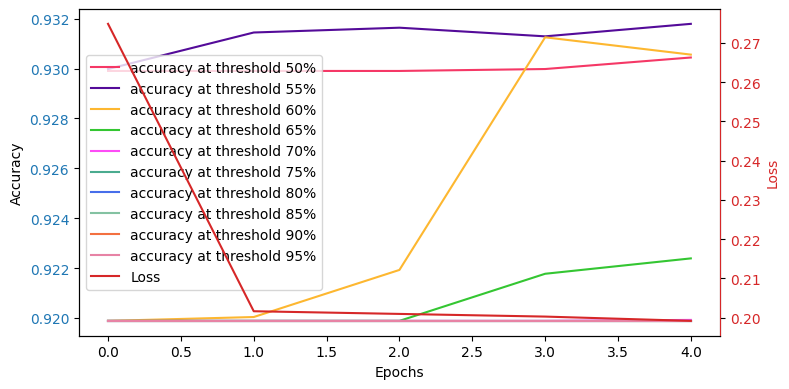

In [97]:
dg = Diagram()
dg.show_stats_fit_by_epochs(ex.accuracy_dict, ex.loss_mean_list)

In [98]:
# model_data = torch.load('/kaggle/working/models/dendensenet121/2025-05-10 04:30:55/save_each_epoch/epoch_5.tar', weights_only=True, map_location=device)

# state_dict = {k.replace('module.', ''): v for k, v in model_data['model'].items()}
# model.load_state_dict(state_dict)

# ex.model = model.to(device)

In [99]:
d_test = XRayDataset(DATASET_DIR_PATH, 'test', NUM_CLASSES, transform=transforms, unpack_parquet=False)
test_dataset = data.DataLoader(d_test, batch_size=20, shuffle=False)

In [100]:
labels, preds, probs = ex.evaluate(test_dataset, device)

Evaluating: 100%|██████████| 64/64 [01:23<00:00,  1.31s/it]


In [ ]:
report = classification_report(
    labels.numpy(), 
    preds.numpy(), 
    output_dict=True
)
print(f"\nTest Average Precision: {report['macro avg']['precision']:.4f}")
print(f"Test Average Recall: {report['macro avg']['recall']:.4f}")
print(f"Test Average F1-score: {report['macro avg']['f1-score']:.4f}")

print('='*10)
for i in range(NUM_CLASSES):
    d = dict(report[str(i)])
    print(f'Number class: {i}')
    print(f'Precision: {d["precision"]:.2}')
    print(f'Recall: {d["recall"]}')
    print(f'F1-score: {d["f1-score"]}')
    print(f'Support: {d["support"]}')
    print('='*10)
# print(report['0'])
# print(report['14'])


Test Average Precision: 0.0282
Test Average Recall: 0.0667
Test Average F1-score: 0.0396
Number class: 0
Precision: 0.42
Recall: 1.0
F1-score: 0.59
Support: 541
Number class: 1
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 160
Number class: 2
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 30
Number class: 3
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 133
Number class: 4
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 190
Number class: 5
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 37
Number class: 6
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 31
Number class: 7
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 4
Number class: 8
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 79
Number class: 9
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 27
Number class: 10
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 4
Number class: 11
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 15
Number class: 12
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Support: 15
Number

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


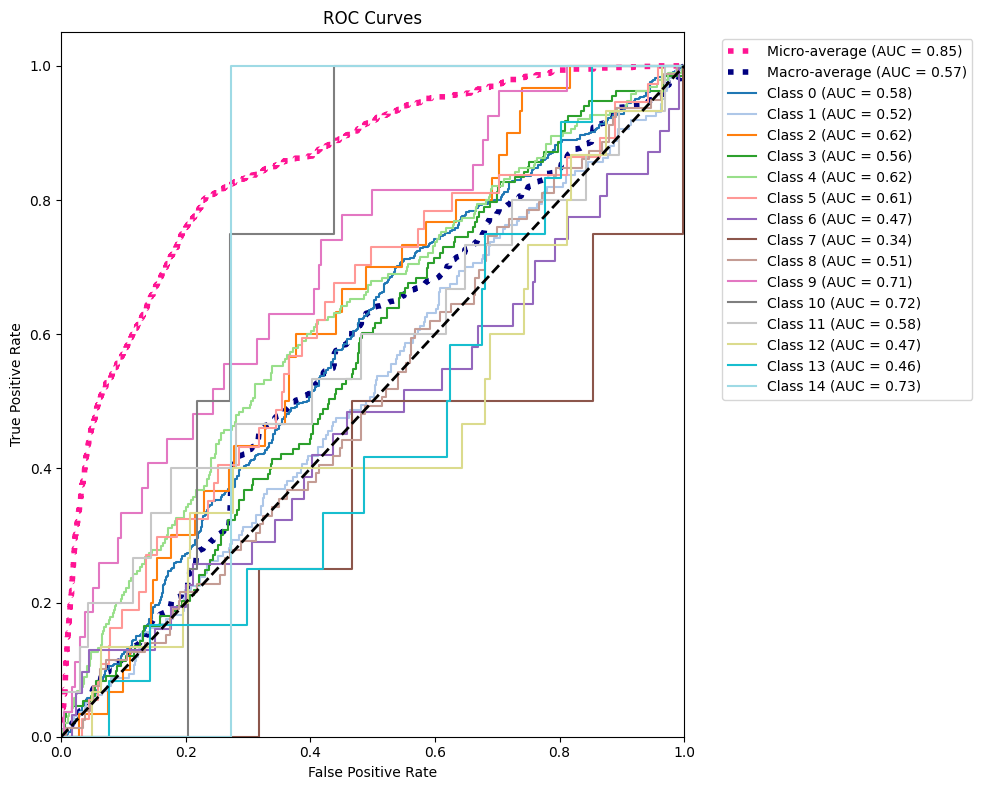

{0: 0.5831492418436199,
 1: 0.5154602323503128,
 2: 0.6197491326394449,
 3: 0.5615019223451299,
 4: 0.6222512203373447,
 5: 0.6105235670453062,
 6: 0.4677160876757651,
 7: 0.3409803921568627,
 8: 0.5072257383966245,
 9: 0.7060998698378891,
 10: 0.7176470588235293,
 11: 0.5753691983122363,
 12: 0.4689345991561181,
 13: 0.46237832149434355,
 14: 0.7269170579029733,
 'micro': 0.8498811926097951,
 'macro': 0.566249138157999}

In [102]:
dg.multiclass_roc(labels=labels, probs=probs, num_classes=NUM_CLASSES)